In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import matplotlib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [55]:
data = pd.read_csv('红酒质量-已清洗.csv')
X = data.drop('quality', axis=1)  

In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [59]:
pca = PCA()
pca.fit(X_scaled)

PCA()

In [61]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()  # 累积方差

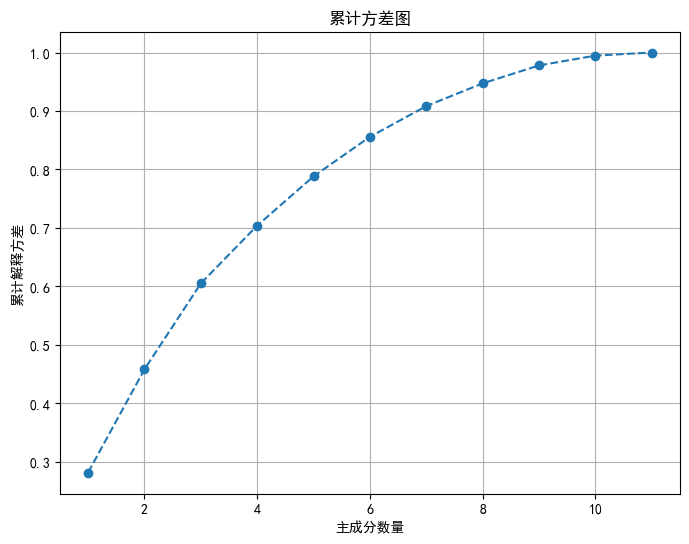

In [63]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示为方块的问题
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('主成分数量')
plt.ylabel('累计解释方差')
plt.title('累计方差图')
plt.grid(True)
plt.savefig("累计方差图.png", dpi=300) 
plt.show()


In [65]:
threshold = 0.95  # 设置一个阈值，例如95%的方差
n_components = (cumulative_variance >= threshold).argmax() + 1
print(f"选择的主成分数量：{n_components} (累计方差超过 {threshold*100}% 的点)")

选择的主成分数量：9 (累计方差超过 95.0% 的点)


In [67]:
X = data.drop(['quality'], axis=1)
Y = data['quality']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

In [69]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [71]:
pca = PCA(n_components=0.95) 
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [73]:
svc = SVC(probability=True)  
svc.fit(X_train_pca, Y_train)

SVC(probability=True)

In [75]:
X_train_prediction = svc.predict(X_train_pca)
train_data_accuracy = accuracy_score(X_train_prediction,Y_train)
f1_train =f1_score(X_train_prediction,Y_train,average='weighted')
print(train_data_accuracy)
print(f1_train)

0.6768488745980707
0.7019117049960303


In [77]:
X_test_prediction = svc.predict(X_test_pca)
test_data_accuracy = accuracy_score(X_test_prediction,Y_test)
f1_test =f1_score(X_test_prediction,Y_test,average='weighted')
print(test_data_accuracy)
print(f1_test)

0.6077170418006431
0.635964032812161


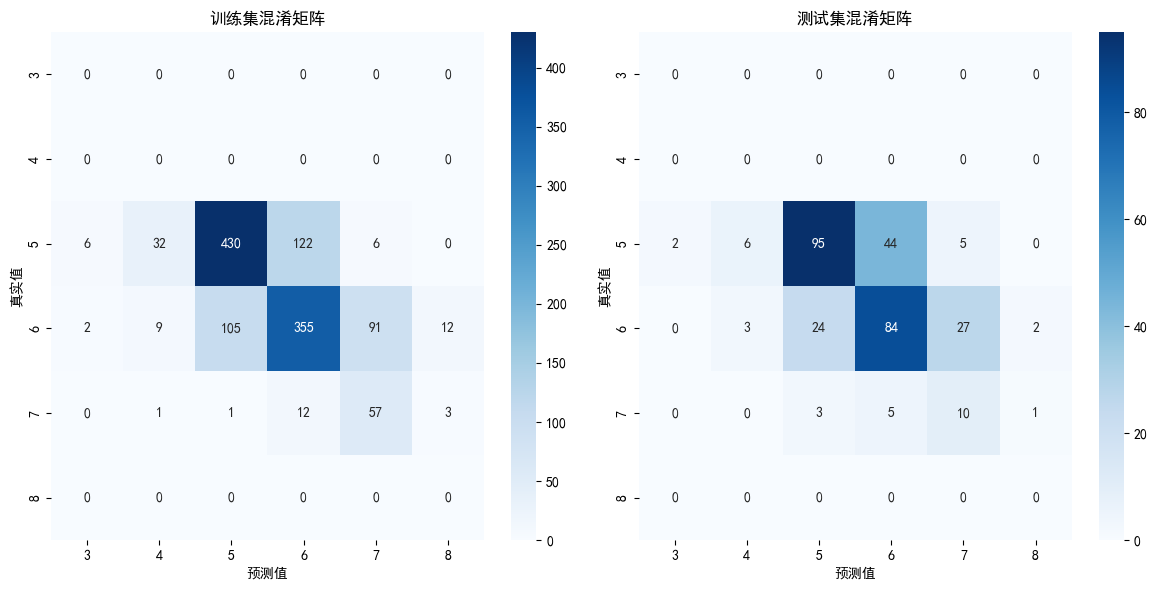

In [79]:
conf_matrix = confusion_matrix(X_train_prediction,Y_train)
conf_matrix_test = confusion_matrix(X_test_prediction,Y_test)

# 设置图形大小
fig_size = (12, 6)  # 12 英寸宽, 6 英寸高
fig, ax = plt.subplots(1, 2, figsize=fig_size)

# 绘制训练集的混淆矩阵
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[3, 4, 5, 6, 7, 8],  # 根据你的分类标签修改
            yticklabels=[3, 4, 5, 6, 7, 8], ax=ax[0])  # 使用ax[0]指定在哪个子图上绘制
ax[0].set_ylabel('真实值')
ax[0].set_xlabel('预测值')
ax[0].set_title('训练集混淆矩阵')

# 绘制测试集的混淆矩阵
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[3, 4, 5, 6, 7, 8],  # 根据你的分类标签修改
            yticklabels=[3, 4, 5, 6, 7, 8], ax=ax[1])  # 使用ax[1]指定在哪个子图上绘制
ax[1].set_ylabel('真实值')
ax[1].set_xlabel('预测值')
ax[1].set_title('测试集混淆矩阵')

# 自动调整布局
plt.tight_layout()
plt.savefig("svc-PCA.png", dpi=300, bbox_inches='tight') 
# 显示图形
plt.show()

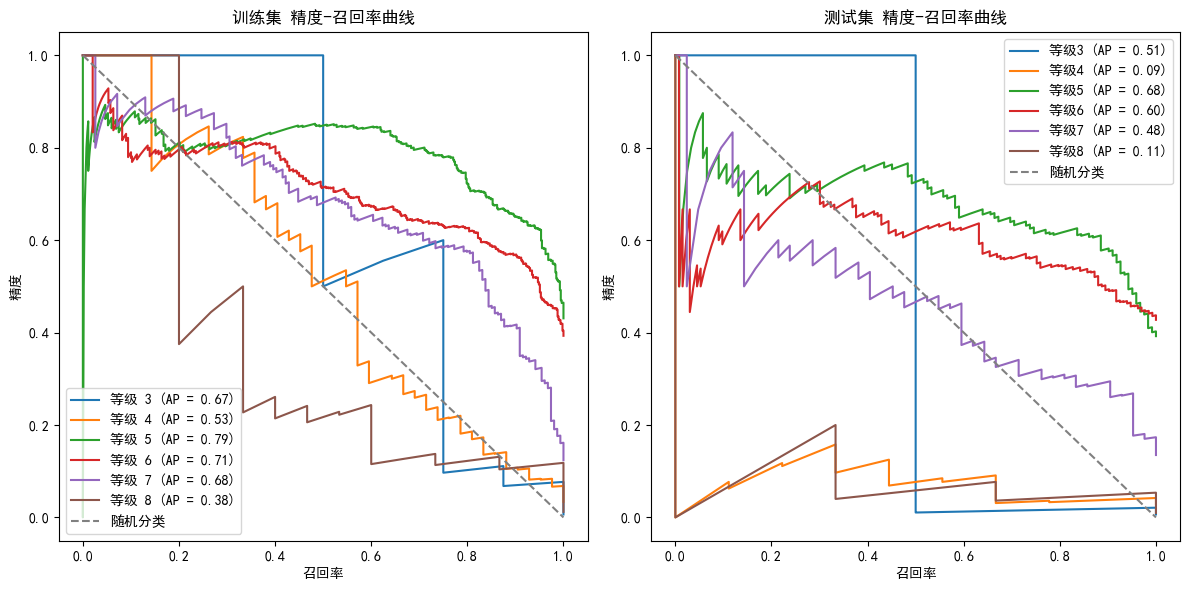

In [85]:
Y_train_probs = svc.predict_proba(X_train_pca)
unique_classes_train = np.unique(Y_train)

# 获取测试集的预测概率
Y_test_probs = svc.predict_proba(X_test_pca)
unique_classes_test = np.unique(Y_test)

# 设置图形大小和子图的排列 (1 行 2 列)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 绘制训练集的精度-召回率曲线
for i in unique_classes_train:
    precision, recall, _ = precision_recall_curve(Y_train == i, Y_train_probs[:, i-3])
    ax[0].plot(recall, precision, label=f'等级 {i} (AP = {average_precision_score(Y_train == i, Y_train_probs[:, i-3]):.2f})')

# 绘制测试集的精度-召回率曲线
for i in unique_classes_test:
    precision, recall, _ = precision_recall_curve(Y_test == i, Y_test_probs[:, i-3])
    ax[1].plot(recall, precision, label=f'等级{i} (AP = {average_precision_score(Y_test == i, Y_test_probs[:, i-3]):.2f})')

# 在两个子图中分别绘制随机分类器的对角线
ax[0].plot([0, 1], [1, 0], linestyle='--', color='gray', label='随机分类')
ax[1].plot([0, 1], [1, 0], linestyle='--', color='gray', label='随机分类')

# 设置标题、标签和图例
ax[0].set_title('训练集 精度-召回率曲线')
ax[0].set_xlabel('召回率')
ax[0].set_ylabel('精度')
ax[0].legend(loc='best')

ax[1].set_title('测试集 精度-召回率曲线')
ax[1].set_xlabel('召回率')
ax[1].set_ylabel('精度')
ax[1].legend(loc='best')
plt.savefig("svr-PCA-精度召回率-默认.png", dpi=300, bbox_inches='tight') 
# 自动调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [87]:
df = pd.read_csv('红酒质量-已清洗.csv')
X = df.drop('quality', axis=1)
Y = df['quality']
Y = Y - 3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [89]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [91]:
pca = PCA(n_components=0.95) 
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [93]:
model = Sequential()
model.add(Dense(64, input_dim=X_train_pca.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))  # 6个类别（3-8）

In [95]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [97]:
history = model.fit(X_train_pca, Y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
32/32 [==============================] - 1s 5ms/step - loss: 1.5833 - accuracy: 0.3920 - val_loss: 1.3725 - val_accuracy: 0.5301
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 1.2073 - accuracy: 0.5377 - val_loss: 1.2303 - val_accuracy: 0.5422
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 1.0925 - accuracy: 0.5769 - val_loss: 1.1581 - val_accuracy: 0.5904
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 1.0330 - accuracy: 0.6131 - val_loss: 1.1096 - val_accuracy: 0.6145
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.9978 - accuracy: 0.6000 - val_loss: 1.0848 - val_accuracy: 0.6024
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.9703 - accuracy: 0.6151 - val_loss: 1.0646 - val_accuracy: 0.6345
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.9533 - accuracy: 0.6181 - val_loss: 1.0504 - val_accuracy: 0.6024
Epoch 8/100
3

In [98]:
Y_train_pred = model.predict(X_train_pca)
Y_train_pred_max = np.argmax(Y_train_pred, axis=1)
accuracy = accuracy_score(Y_train_pred_max, Y_train)
print(f"Accuracy: {accuracy:.4f}")
f1_train= f1_score(Y_train_pred_max, Y_train, average='weighted')
print(f1_train)

39/39 [==============================] - 0s 605us/step
Accuracy: 0.7733
0.7777838381930752


In [99]:
Y_test_pred = model.predict(X_test_pca)
Y_test_pred_max = np.argmax(Y_test_pred, axis=1)
accuracy = accuracy_score(Y_test_pred_max, Y_test)
print(f"Accuracy: {accuracy:.4f}")
f1_test= f1_score(Y_test_pred_max, Y_test, average='weighted')
print(f1_test)

10/10 [==============================] - 0s 1ms/step
Accuracy: 0.5884
0.5920278555119479


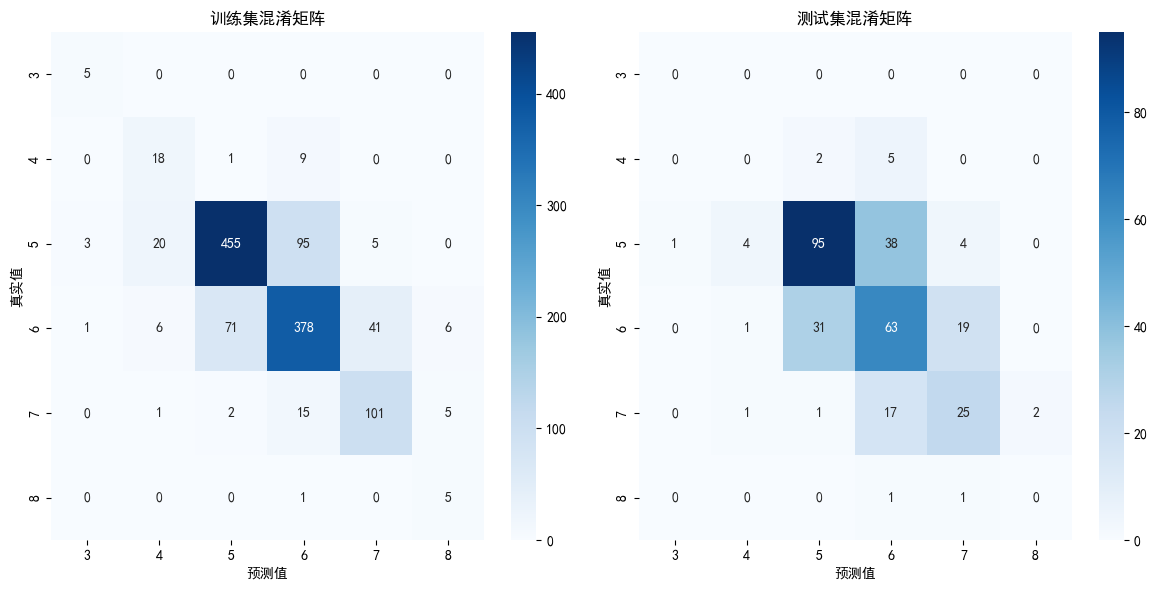

In [103]:
conf_matrix = confusion_matrix(Y_train_pred_max, Y_train)
conf_matrix_test = confusion_matrix(Y_test_pred_max, Y_test)

# 设置图形大小
fig_size = (12, 6)  # 12 英寸宽, 6 英寸高
fig, ax = plt.subplots(1, 2, figsize=fig_size)

# 绘制训练集的混淆矩阵
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[3, 4, 5, 6, 7, 8],  # 根据你的分类标签修改
            yticklabels=[3, 4, 5, 6, 7, 8], ax=ax[0])  # 使用ax[0]指定在哪个子图上绘制
ax[0].set_ylabel('真实值')
ax[0].set_xlabel('预测值')
ax[0].set_title('训练集混淆矩阵')

# 绘制测试集的混淆矩阵
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[3, 4, 5, 6, 7, 8],  # 根据你的分类标签修改
            yticklabels=[3, 4, 5, 6, 7, 8], ax=ax[1])  # 使用ax[1]指定在哪个子图上绘制
ax[1].set_ylabel('真实值')
ax[1].set_xlabel('预测值')
ax[1].set_title('测试集混淆矩阵')

# 自动调整布局
plt.tight_layout()
plt.savefig("NN-PCA.png", dpi=300, bbox_inches='tight') 
# 显示图形
plt.show()

10/10 [==============================] - 0s 778us/step


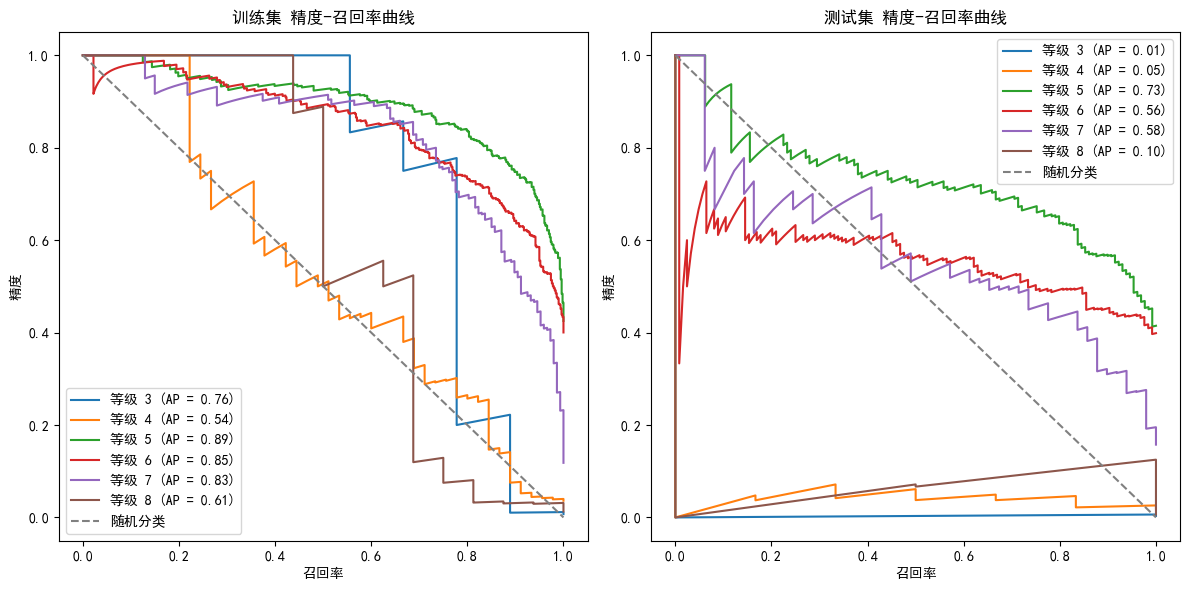

In [109]:
Y_train_probs = model.predict(X_train_pca)
Y_test_probs = model.predict(X_test_pca)

# 获取唯一类别标签
unique_classes_train = np.unique(Y_train)
unique_classes_test = np.unique(Y_test)

# 设置图形大小和子图的排列 (1 行 2 列)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 绘制训练集的精度-召回率曲线
for i in unique_classes_train:
    precision, recall, _ = precision_recall_curve(Y_train == i, Y_train_probs[:, i])
    average_precision = average_precision_score(Y_train == i, Y_train_probs[:, i])
    ax[0].plot(recall, precision, label=f'等级 {i+3} (AP = {average_precision:.2f})')

# 绘制测试集的精度-召回率曲线
for i in unique_classes_test:
    precision, recall, _ = precision_recall_curve(Y_test == i, Y_test_probs[:, i])
    average_precision = average_precision_score(Y_test == i, Y_test_probs[:, i])
    ax[1].plot(recall, precision, label=f'等级 {i+3} (AP = {average_precision:.2f})')

# 在两个子图中分别绘制随机分类器的对角线
ax[0].plot([0, 1], [1, 0], linestyle='--', color='gray', label='随机分类')
ax[1].plot([0, 1], [1, 0], linestyle='--', color='gray', label='随机分类')

# 设置标题、标签和图例
ax[0].set_title('训练集 精度-召回率曲线')
ax[0].set_xlabel('召回率')
ax[0].set_ylabel('精度')
ax[0].legend(loc='best')

ax[1].set_title('测试集 精度-召回率曲线')
ax[1].set_xlabel('召回率')
ax[1].set_ylabel('精度')
ax[1].legend(loc='best')

# 保存并显示图形
plt.tight_layout()
plt.savefig("nn-PCA-精度召回率-默认.png", dpi=300, bbox_inches='tight') 
plt.show()